In [99]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from copy import deepcopy
import sunpy
import sunpy.map
import astropy
from astropy import units as u
from astropy.coordinates import SkyCoord

In [5]:
with fits.open("../../src/CHASE/20221024/RSM20221024T191230_0022_HA.fits") as hdul:
    hdul.info()
    chase_halpha_data = hdul[1].data[:]
    chase_header = deepcopy(hdul[1].header)

Filename: ../../src/CHASE/20221024/RSM20221024T191230_0022_HA.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  COMPRESSED_IMAGE    1 CompImageHDU     48   (2304, 2313, 118)   int16   


In [6]:
sample_spec = chase_halpha_data[:, 600, 700]
chase_wavelength = (np.arange(chase_header["NAXIS3"]) + 1 - (chase_header["CRPIX3"] + 1))*chase_header["CDELT3"] + chase_header["CRVAL3"]

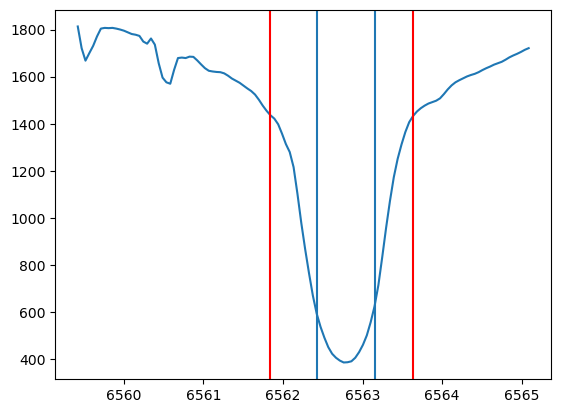

In [49]:
line_core_slice = np.s_[62:77]
line_slice = np.s_[50:87]
plt.plot(chase_wavelength, sample_spec)
plt.axvline(chase_wavelength[line_core_slice.start])
plt.axvline(chase_wavelength[line_core_slice.stop])
plt.axvline(chase_wavelength[line_slice.start], color="red")
plt.axvline(chase_wavelength[line_slice.stop], color="red")

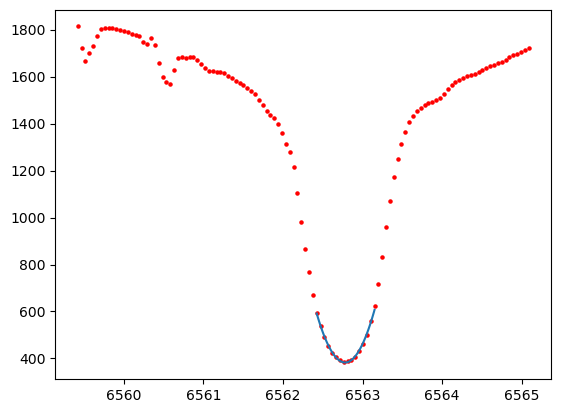

In [40]:
sample_line_core_poly_fit_param = np.polyfit(chase_wavelength[line_core_slice], sample_spec[line_core_slice], 2)
sample_line_core_poly_fit = np.poly1d(sample_line_core_poly_fit_param)

plt.scatter(chase_wavelength, sample_spec,marker="o",color="r",s=5)

plt.plot(np.linspace(chase_wavelength[line_core_slice.start],
                     chase_wavelength[line_core_slice.stop],100),
        sample_line_core_poly_fit(np.linspace(chase_wavelength[line_core_slice.start],
                     chase_wavelength[line_core_slice.stop],100)))





In [44]:
sample_line_cen = - sample_line_core_poly_fit_param[1] / (2 * sample_line_core_poly_fit_param[0])
sample_line_min = sample_line_core_poly_fit_param[2] - sample_line_core_poly_fit_param[1]**2/(4*sample_line_core_poly_fit_param[0]) 
sample_line_cen, sample_line_min

(6562.780897324226, 383.0321807861328)

In [60]:
sample_line_wing_int = (np.interp(sample_line_cen - 1., chase_wavelength, sample_spec) + \
                    np.interp(sample_line_cen + 1., chase_wavelength, sample_spec)) / 2 

In [61]:
sample_half_int = (sample_line_min + sample_line_wing_int) / 2

In [68]:
sample_line_width =  np.interp(sample_half_int, sample_spec[line_core_slice.stop:line_slice.stop], chase_wavelength[line_core_slice.stop:line_slice.stop])- \
                    np.interp(sample_half_int, np.flip(sample_spec[line_slice.start:line_core_slice.start]), np.flip(chase_wavelength[line_slice.start:line_core_slice.start]))

In [74]:
sample_line_width

1.0305521385762404

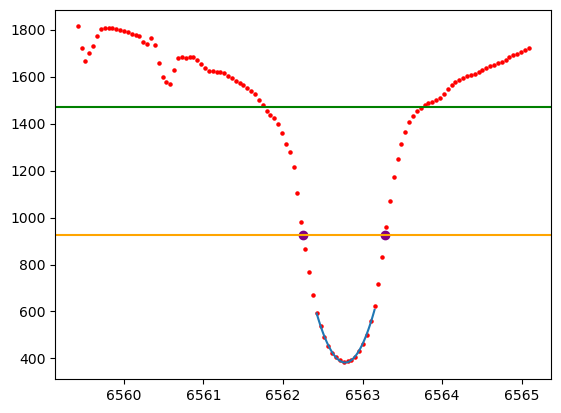

In [71]:
sample_line_core_poly_fit_param = np.polyfit(chase_wavelength[line_core_slice], sample_spec[line_core_slice], 2)
sample_line_core_poly_fit = np.poly1d(sample_line_core_poly_fit_param)

plt.scatter(chase_wavelength, sample_spec,marker="o",color="r",s=5)

plt.plot(np.linspace(chase_wavelength[line_core_slice.start],
                     chase_wavelength[line_core_slice.stop],100),
        sample_line_core_poly_fit(np.linspace(chase_wavelength[line_core_slice.start],
                     chase_wavelength[line_core_slice.stop],100)))

plt.axhline(sample_line_wing_int, color="green")
plt.axhline(sample_half_int, color="orange")

plt.scatter(np.interp(sample_half_int, sample_spec[line_core_slice.stop:line_slice.stop], chase_wavelength[line_core_slice.stop:line_slice.stop]), 
            sample_half_int,color="purple")
plt.scatter(np.interp(sample_half_int, np.flip(sample_spec[line_slice.start:line_core_slice.start]), np.flip(chase_wavelength[line_slice.start:line_core_slice.start])),
            sample_half_int,color="purple")

In [89]:
def find_line_width(wvl,spec):
    if spec[-1] < 100:
        return np.nan
    else:
        line_core_fit_param = np.polyfit(wvl[line_core_slice], spec[line_core_slice], 2)
        line_core_fit = np.poly1d(line_core_fit_param)

        line_cen = - line_core_fit_param[1] / (2 * line_core_fit_param[0])
        line_min = line_core_fit_param[2] - line_core_fit_param[1]**2/(4*line_core_fit_param[0])
        
        line_wing_int = (np.interp(line_cen - 1., wvl, spec) + \
                        np.interp(line_cen + 1., wvl, spec)) / 2
        
        half_int = (line_min + line_wing_int) / 2

        line_width =  np.interp(half_int, spec[line_core_slice.stop:line_slice.stop], wvl[line_core_slice.stop:line_slice.stop])- \
                        np.interp(half_int, np.flip(spec[line_slice.start:line_core_slice.start]), np.flip(wvl[line_slice.start:line_core_slice.start]))
        return line_width

In [90]:
find_line_width(chase_wavelength, sample_spec)

1.0305521385762404

In [91]:
chase_halpha_data_flat = chase_halpha_data.reshape(chase_halpha_data.shape[0], -1)

In [92]:
chase_halpha_data_flat.shape

(118, 5329152)

In [93]:
chase_halpha_line_width = np.zeros(chase_halpha_data_flat.shape[1])

In [94]:
for ii in range(chase_halpha_data_flat.shape[1]):
    chase_halpha_line_width[ii] = find_line_width(chase_wavelength, chase_halpha_data_flat[:,ii])

In [95]:
chase_halpha_line_width = chase_halpha_line_width.reshape(chase_halpha_data.shape[1:])

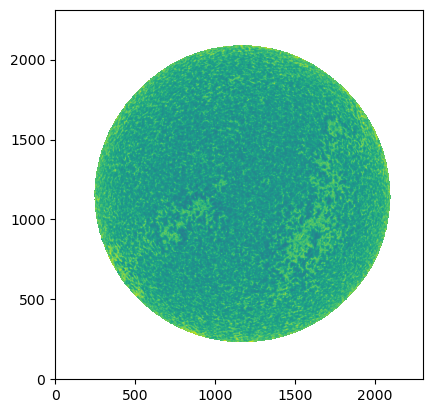

In [97]:
plt.imshow(chase_halpha_line_width,vmin=0.5,vmax=1.5,origin="lower")

In [100]:
chase_fits_header = sunpy.map.make_fitswcs_header(chase_halpha_line_width.shape,
                                                  SkyCoord(chase_header["CRVAL1"]*u.arcsec,chase_header["CRVAL2"]*u.arcsec,
                                                           obstime=chase_header["DATE_OBS"],observer="Earth",frame="helioprojective"),
                                                  reference_pixel=[chase_header["CRPIX1"],chase_header["CRPIX2"]]*u.pix,
                                                  scale=u.Quantity([0.5218*2,0.5218*2],u.arcsec/u.pix),
                                                  rotation_angle=-chase_header["INST_ROT"]*u.deg,
                                                  telescope="CHASE",instrument="RSM")

In [103]:
chase_halpha_line_width_map = sunpy.map.Map(chase_halpha_line_width,chase_fits_header)
chase_halpha_line_width_map.save("../../src/CHASE/20221024/RSM20221024T191230_0022_HA_linewidth.fits")